In [1]:
import netCDF4 as nc
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Borglum

In [2]:
file_path_borglum = 'borglum_all.nc'

dataset = nc.Dataset(file_path_borglum, 'r')

Load mast data in a dataframe

In [56]:
# as we have found out the qc values are either 0 or nan. So we guess it means quality control
# and we think we can remove those

# lets convert data to dataframe
column_names = []
for var_name in dataset.variables:
    column_names.append(var_name)
    
df_data = pd.DataFrame()
for column_name in column_names:
    tmp_np = np.array(dataset.variables[column_name])
    df_data[column_name] = tmp_np
df_data.describe()

,time,ws32,ws32_qc,ws20,ws20_qc,ws10,ws10_qc,wd10,wd10_qc,wd32,...,td10_2,td10_2_qc,td30_10,td30_10_qc,rhum,rhum_qc,grad,grad_qc,press,press_qc
count,2.122790e+05,211046.000000,211046.0,198670.000000,198670.0,206247.000000,206247.0,212270.000000,212270.0,204907.000000,...,212279.000000,212279.0,212279.000000,212279.0,212276.000000,212276.0,212279.000000,212279.0,205453.000000,205453.0
mean,1.067308e+06,6.618591,0.0,6.027335,0.0,5.443917,0.0,182.720479,0.0,185.061560,...,0.139489,0.0,0.054420,0.0,81.749322,0.0,112.399173,0.0,1009.414265,0.0
std,6.171817e+05,3.299422,0.0,3.172190,0.0,3.008973,0.0,91.017378,0.0,90.418746,...,0.683429,0.0,0.599545,0.0,14.878764,0.0,178.268002,0.0,11.623661,0.0
min,0.000000e+00,0.120000,0.0,0.100000,0.0,0.100000,0.0,0.000000,0.0,0.000000,...,-2.740000,0.0,-2.330000,0.0,0.000000,0.0,0.000000,0.0,954.700000,0.0
25%,5.306950e+05,4.240000,0.0,3.730000,0.0,3.200000,0.0,113.000000,0.0,117.000000,...,-0.130000,0.0,-0.210000,0.0,74.000000,0.0,15.000000,0.0,1002.160000,0.0
50%,1.071720e+06,6.080000,0.0,5.520000,0.0,4.970000,0.0,188.000000,0.0,192.000000,...,0.050000,0.0,-0.120000,0.0,84.000000,0.0,20.000000,0.0,1009.920000,0.0
75%,1.602415e+06,8.590000,0.0,7.950000,0.0,7.280000,0.0,262.000000,0.0,261.000000,...,0.280000,0.0,0.110000,0.0,95.000000,0.0,124.000000,0.0,1017.170000,0.0
max,2.133110e+06,26.260000,0.0,25.280000,0.0,23.550000,0.0,360.000000,0.0,360.000000,...,6.910000,0.0,8.730000,0.0,98.000000,0.0,1116.000000,0.0,1396.950000,0.0


In [57]:
df_data = df_data.dropna()
df_data.describe()

,time,ws32,ws32_qc,ws20,ws20_qc,ws10,ws10_qc,wd10,wd10_qc,wd32,...,td10_2,td10_2_qc,td30_10,td30_10_qc,rhum,rhum_qc,grad,grad_qc,press,press_qc
count,1.876850e+05,187685.000000,187685.0,187685.000000,187685.0,187685.000000,187685.0,187685.000000,187685.0,187685.000000,...,187685.000000,187685.0,187685.000000,187685.0,187685.000000,187685.0,187685.000000,187685.0,187685.000000,187685.0
mean,1.077894e+06,6.568099,0.0,6.026508,0.0,5.416601,0.0,181.244836,0.0,182.505602,...,0.132310,0.0,0.052818,0.0,81.663116,0.0,117.611621,0.0,1009.401590,0.0
std,6.111101e+05,3.256324,0.0,3.177134,0.0,2.980523,0.0,91.045161,0.0,90.315178,...,0.695041,0.0,0.601651,0.0,15.061845,0.0,182.694232,0.0,11.550644,0.0
min,4.744000e+04,0.120000,0.0,0.100000,0.0,0.100000,0.0,0.000000,0.0,0.000000,...,-2.740000,0.0,-2.330000,0.0,0.000000,0.0,0.000000,0.0,968.270000,0.0
25%,5.282200e+05,4.240000,0.0,3.730000,0.0,3.200000,0.0,111.000000,0.0,114.000000,...,-0.130000,0.0,-0.210000,0.0,74.000000,0.0,15.000000,0.0,1002.170000,0.0
50%,1.086420e+06,6.030000,0.0,5.520000,0.0,4.940000,0.0,187.000000,0.0,189.000000,...,0.050000,0.0,-0.120000,0.0,84.000000,0.0,20.000000,0.0,1009.910000,0.0
75%,1.620740e+06,8.520000,0.0,7.970000,0.0,7.240000,0.0,261.000000,0.0,260.000000,...,0.280000,0.0,0.110000,0.0,95.000000,0.0,135.000000,0.0,1017.020000,0.0
max,2.133110e+06,26.260000,0.0,25.280000,0.0,23.550000,0.0,360.000000,0.0,360.000000,...,6.910000,0.0,8.730000,0.0,98.000000,0.0,1116.000000,0.0,1396.950000,0.0


In [58]:
df_data.columns.values

#remove qc columns
df_cols_to_drop = []
for col in df_data.columns.values:
    if col.endswith("_qc"):
        df_cols_to_drop.append(col)
        
df_mast = df_data.drop(df_cols_to_drop, axis=1)

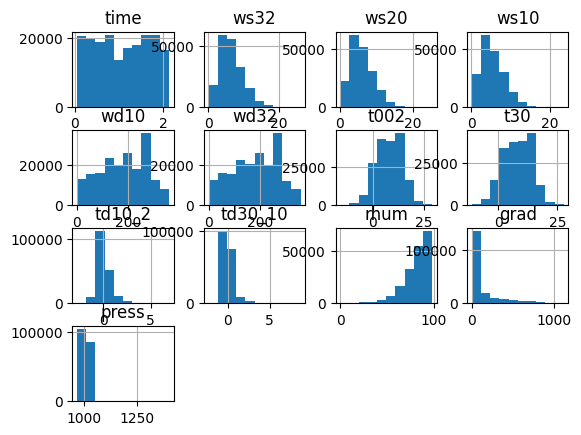

In [59]:
#histogram for all mast columns
df_mast.hist()
print("")

,ws32,ws20,ws10,wd10,wd32,t002,t30,td10_2,td30_10
ws32,1.000000,0.984009,0.986521,NaN,NaN,NaN,NaN,NaN,NaN
ws20,0.984009,1.000000,0.984437,NaN,NaN,NaN,NaN,NaN,NaN
ws10,0.986521,0.984437,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
wd10,NaN,NaN,NaN,1.000000,0.944028,NaN,NaN,NaN,NaN
wd32,NaN,NaN,NaN,0.944028,1.000000,NaN,NaN,NaN,NaN
t002,NaN,NaN,NaN,NaN,NaN,1.000000,0.981016,NaN,NaN
t30,NaN,NaN,NaN,NaN,NaN,0.981016,1.000000,NaN,NaN
td10_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.760761
td30_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.760761,1.000000


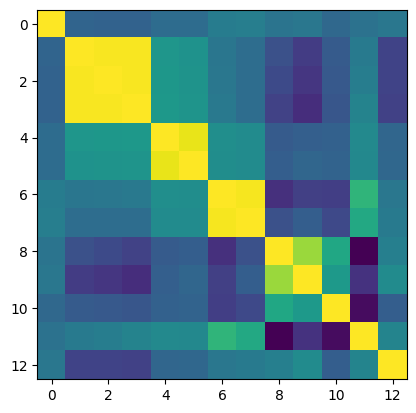

In [60]:
plt.imshow(df_mast.corr())
# display only columns with correlation higher than 0.75
my_corr = df_mast.corr()
my_corr[my_corr > 0.75].dropna(thresh=2).dropna(thresh=2, axis=1)

In [61]:
# convert time from mast to timestamp
base_date_borglum = datetime(1997, 12, 11, 16, 5, 0)
base_date_risoe = datetime(1995, 11, 20, 16, 25, 0)

def time_convert(input):
    time_delta = timedelta(minutes=int(input))
    timestamp = base_date_borglum + time_delta
    return pd.to_datetime(timestamp)
    # return timestamp.strftime('%Y-%m-%d %H:%M:%S')


for index, row in df_mast.iterrows():
    time = row['time']
    time_stamp = time_convert(time)
    df_mast.at[index, 'TIMESTAMP'] = time_stamp

df_mast['TIMESTAMP'] = pd.to_datetime(df_mast['TIMESTAMP'])

we chose to use ws and wd for height 125 in mast so all the other columns that are no longer relevant are dropped

In [62]:
df_mast.head(10)
df_mast_just_wind = df_mast.drop(['time','ws20','ws10','wd10','t002','t30','td10_2','td30_10','press','rhum','grad'], axis=1)
df_mast_just_wind.head()

,ws32,wd32,TIMESTAMP
4744,3.04,128.0,1998-01-13 14:45:00
4745,3.54,116.0,1998-01-13 14:55:00
4746,3.77,113.0,1998-01-13 15:05:00
4747,3.97,116.0,1998-01-13 15:15:00
4748,4.47,117.0,1998-01-13 15:25:00


created a new season column based on the timestamp

In [63]:
df_mast_wind_month = df_mast_just_wind.copy()

df_mast_wind_month.dtypes

print(((df_mast['TIMESTAMP'].dt.month + 1) // 4) + 1)
df_mast_wind_month['season'] = ((df_mast['TIMESTAMP'].dt.month + 1) // 4) + 1
df_mast_wind_month['year'] = df_mast['TIMESTAMP'].dt.year

df_mast_wind_month.head(10)

4744      1
4745      1
4746      1
4747      1
4748      1
         ..
212274    4
212275    4
212276    4
212277    4
212278    4
Name: TIMESTAMP, Length: 187685, dtype: int32


,ws32,wd32,TIMESTAMP,season,year
4744,3.04,128.0,1998-01-13 14:45:00,1,1998
4745,3.54,116.0,1998-01-13 14:55:00,1,1998
4746,3.77,113.0,1998-01-13 15:05:00,1,1998
4747,3.97,116.0,1998-01-13 15:15:00,1,1998
4748,4.47,117.0,1998-01-13 15:25:00,1,1998
4749,3.70,117.0,1998-01-13 15:35:00,1,1998
4750,4.04,121.0,1998-01-13 15:45:00,1,1998
4751,4.57,119.0,1998-01-13 15:55:00,1,1998
4752,5.71,128.0,1998-01-13 16:05:00,1,1998
4753,4.88,129.0,1998-01-13 16:15:00,1,1998


In [64]:
#set the wind direction to 0 if 360 to avoid the avg becoming 180; also 0 and 360 are kind of the same thing
df_mast_wind_month.loc[df_mast_wind_month['wd32'] == 360, 'wd32'] = 0

df_mast_wind_month.describe()

,ws32,wd32,TIMESTAMP,season,year
count,187685.000000,187685.000000,187685,187685.000000,187685.000000
mean,6.568099,182.304201,1999-12-30 04:58:53.430482176,2.500930,1999.496001
min,0.120000,0.000000,1998-01-13 14:45:00,1.000000,1998.000000
25%,4.240000,114.000000,1998-12-13 11:45:00,2.000000,1998.000000
50%,6.030000,189.000000,2000-01-05 03:05:00,2.000000,2000.000000
75%,8.520000,260.000000,2001-01-10 04:25:00,3.000000,2001.000000
max,26.260000,359.000000,2001-12-31 23:55:00,4.000000,2001.000000
std,3.256324,90.320541,NaN,0.933223,1.136869


In [65]:
#create columns for east and north based on cartesian coordinates for the wind speed and wind direction
df_mast_wind_month_cartesian = df_mast_wind_month.copy()

df_mast_wind_month_cartesian['east'] = df_mast_wind_month_cartesian['ws32'] * np.sin((df_mast_wind_month_cartesian['wd32']/360) * 2*np.pi)
df_mast_wind_month_cartesian['north'] = df_mast_wind_month_cartesian['ws32'] * np.cos((df_mast_wind_month_cartesian['wd32']/360) * 2*np.pi)

df_mast_wind_month_cartesian.head(10)

,ws32,wd32,TIMESTAMP,season,year,east,north
4744,3.04,128.0,1998-01-13 14:45:00,1,1998,2.395553,-1.871611
4745,3.54,116.0,1998-01-13 14:55:00,1,1998,3.181731,-1.551834
4746,3.77,113.0,1998-01-13 15:05:00,1,1998,3.470303,-1.473056
4747,3.97,116.0,1998-01-13 15:15:00,1,1998,3.568212,-1.740333
4748,4.47,117.0,1998-01-13 15:25:00,1,1998,3.982799,-2.029338
4749,3.70,117.0,1998-01-13 15:35:00,1,1998,3.296724,-1.679765
4750,4.04,121.0,1998-01-13 15:45:00,1,1998,3.462956,-2.080754
4751,4.57,119.0,1998-01-13 15:55:00,1,1998,3.997012,-2.215580
4752,5.71,128.0,1998-01-13 16:05:00,1,1998,4.499541,-3.515427
4753,4.88,129.0,1998-01-13 16:15:00,1,1998,3.792472,-3.071084


This is a wind turbine that moves towards the wind direction\
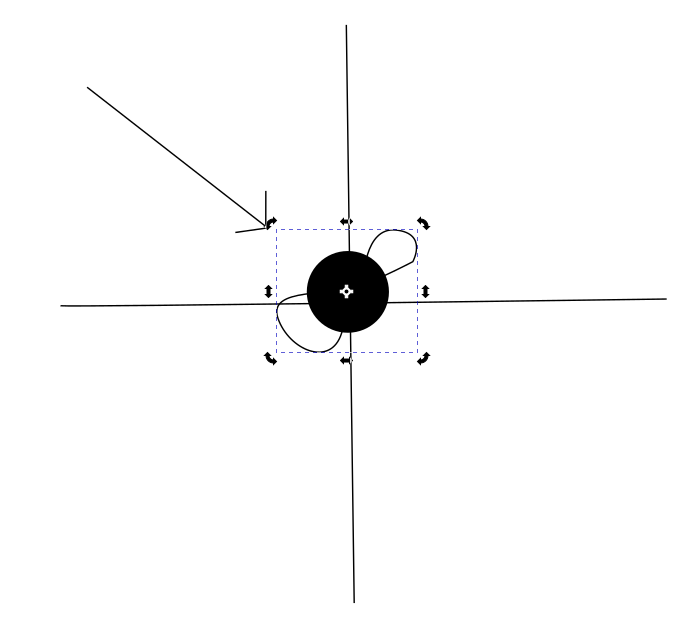

In [66]:
df_mast_wind_month_cartesian['TIMESTAMP'].duplicated().drop_duplicates()
# there are no two times same so we expect that there was no time shift so no need to convert the timestamp to DK time

4744    False
Name: TIMESTAMP, dtype: bool

# Meso part

In [67]:
df_meso = pd.read_csv('Data/Borglum/meso_Borglum.csv')

In [68]:
#convert the datetime
df_meso['TIMESTAMP'] = pd.to_datetime(df_meso['TIMESTAMP'])
df_meso.info()
# df_meso.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204720 entries, 0 to 204719
Data columns (total 74 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   TIMESTAMP   204720 non-null  datetime64[ns]
 1   HGT         204720 non-null  float64       
 2   RHO060      204720 non-null  float64       
 3   RHO080      204720 non-null  float64       
 4   RHO100      204720 non-null  float64       
 5   RHO120      204720 non-null  float64       
 6   RHO140      204720 non-null  float64       
 7   RHO160      204720 non-null  float64       
 8   RHO180      204720 non-null  float64       
 9   RHO200      204720 non-null  float64       
 10  RHO220      204720 non-null  float64       
 11  TC060       204720 non-null  float64       
 12  TC080       204720 non-null  float64       
 13  TC100       204720 non-null  float64       
 14  TC120       204720 non-null  float64       
 15  TC140       204720 non-null  float64       
 16  TC

In [69]:
# find if there are duplicates in date
df_meso['TIMESTAMP'].duplicated().drop_duplicates()


0    False
Name: TIMESTAMP, dtype: bool

In [70]:
#similar to mast, keep only data relevant to the height chosen

df_meso_cleaned = df_meso[['TIMESTAMP','WSP060','WDIR060']]
df_meso_cleaned

,TIMESTAMP,WSP060,WDIR060
0,2000-01-01 07:00:00,9.12,193.41
1,2000-01-01 08:00:00,9.10,191.73
2,2000-01-01 09:00:00,9.13,206.20
3,2000-01-01 10:00:00,8.24,228.57
4,2000-01-01 11:00:00,9.78,290.79
...,...,...,...
204715,2010-02-19 08:00:00,6.70,68.19
204716,2010-02-19 09:00:00,7.19,65.14
204717,2010-02-19 10:00:00,7.42,64.38
204718,2010-02-19 11:00:00,8.71,66.31


In [71]:
#split the timestamp into separate columns and also grouping the mast data into groups of 1 hour
# taking the avg north and east speed for mast and combining them into polar coordinates

df_mast_wind_month_cartesian['year'] = df_mast_wind_month_cartesian['TIMESTAMP'].dt.year
df_mast_wind_month_cartesian['month'] = df_mast_wind_month_cartesian['TIMESTAMP'].dt.month
df_mast_wind_month_cartesian['day'] = df_mast_wind_month_cartesian['TIMESTAMP'].dt.day
df_mast_wind_month_cartesian['hour'] = df_mast_wind_month_cartesian['TIMESTAMP'].dt.hour
mast_hourly_average = df_mast_wind_month_cartesian.groupby(['year', 'month', 'day', 'hour'])['north'].mean().reset_index()
hourly_average_east = df_mast_wind_month_cartesian.groupby(['year', 'month', 'day', 'hour'])['east'].mean().reset_index()

mast_hourly_average['east'] = hourly_average_east['east']
mast_hourly_average['ws32'] = np.sqrt(mast_hourly_average['east']**2 + mast_hourly_average['north']**2)
mast_hourly_average['wd32'] = (np.arctan2(mast_hourly_average['east'], mast_hourly_average['north'])/(2*np.pi)) * 360
mast_hourly_average.head(10)

,year,month,day,hour,north,east,ws32,wd32
0,1998,1,13,14,-1.711722,2.788642,3.272081,121.542409
1,1998,1,13,15,-1.869804,3.629668,4.082972,117.255022
2,1998,1,13,16,-2.575930,4.700544,5.360087,118.723044
3,1998,1,13,17,-3.504741,4.816185,5.956413,126.043404
4,1998,1,13,18,-4.773970,3.540849,5.943770,143.435706
5,1998,1,13,19,-5.988841,2.848138,6.631599,154.565449
6,1998,1,13,20,-4.775560,3.148351,5.719973,146.604607
7,1998,1,13,21,-4.621947,2.613924,5.309896,150.509843
8,1998,1,13,22,-4.690929,2.412719,5.275038,152.781559
9,1998,1,13,23,-4.785768,2.956290,5.625231,148.295328


In [72]:
# convert into datetime 

def time_convert(year,month,day,hour):
    timestamp = datetime(int(year),int(month),int(day),int(hour),0,0)
    return pd.to_datetime(timestamp)
    
for index, row in mast_hourly_average.iterrows():
    time_stamp = time_convert(row['year'],row['month'],row['day'],row['hour'])
    mast_hourly_average.at[index, 'TIMESTAMP'] = time_stamp


In [73]:
# dropped timestamp subsets and added season
mast_hourly_average_calculated = mast_hourly_average.drop(['month','day','hour'], axis=1)

mast_hourly_average_calculated['season'] = ((mast_hourly_average_calculated['TIMESTAMP'].dt.month + 1) // 4) + 1

mast_hourly_average_calculated

,year,north,east,ws32,wd32,TIMESTAMP,season
0,1998,-1.711722,2.788642,3.272081,121.542409,1998-01-13 14:00:00,1
1,1998,-1.869804,3.629668,4.082972,117.255022,1998-01-13 15:00:00,1
2,1998,-2.575930,4.700544,5.360087,118.723044,1998-01-13 16:00:00,1
3,1998,-3.504741,4.816185,5.956413,126.043404,1998-01-13 17:00:00,1
4,1998,-4.773970,3.540849,5.943770,143.435706,1998-01-13 18:00:00,1
...,...,...,...,...,...,...,...
31305,2001,2.610936,-1.946982,3.256950,-36.711996,2001-12-31 19:00:00,4
31306,2001,1.988047,-0.541898,2.060578,-15.247166,2001-12-31 20:00:00,4
31307,2001,2.098691,1.483328,2.569974,35.252186,2001-12-31 21:00:00,4
31308,2001,-0.266234,1.478775,1.502550,100.206002,2001-12-31 22:00:00,4


In [74]:
#join mast and meso data based on timestamp
df_result = mast_hourly_average_calculated.join(df_meso_cleaned.set_index('TIMESTAMP'), on='TIMESTAMP', validate='1:1', rsuffix= 'x', lsuffix='y')
df_result_cleaned = df_result.dropna()
df_result_cleaned.describe()
df_result_cleaned.tail(20)

,year,north,east,ws32,wd32,TIMESTAMP,season,WSP060,WDIR060
31290,2001,-0.464424,-2.939406,2.975869,-98.978470,2001-12-31 04:00:00,4,2.33,227.34
31291,2001,-0.809126,-2.440540,2.571171,-108.342187,2001-12-31 05:00:00,4,1.18,256.25
31292,2001,-2.118930,-2.389713,3.193836,-131.563013,2001-12-31 06:00:00,4,1.56,308.38
31293,2001,-3.531260,-2.036259,4.076291,-150.030607,2001-12-31 07:00:00,4,6.41,319.94
31294,2001,-1.785475,-1.921508,2.622997,-132.898389,2001-12-31 08:00:00,4,6.22,313.96
31295,2001,0.381687,-1.395354,1.446616,-74.701480,2001-12-31 09:00:00,4,5.60,304.34
31296,2001,0.140136,-1.512964,1.519440,-84.708162,2001-12-31 10:00:00,4,6.04,297.82
31297,2001,-0.551640,-1.365663,1.472869,-111.995542,2001-12-31 11:00:00,4,6.33,285.96
31298,2001,-1.856830,-1.457661,2.360634,-141.867145,2001-12-31 12:00:00,4,7.92,285.21
31299,2001,-1.302018,-2.554977,2.867605,-117.003417,2001-12-31 13:00:00,4,8.35,295.11


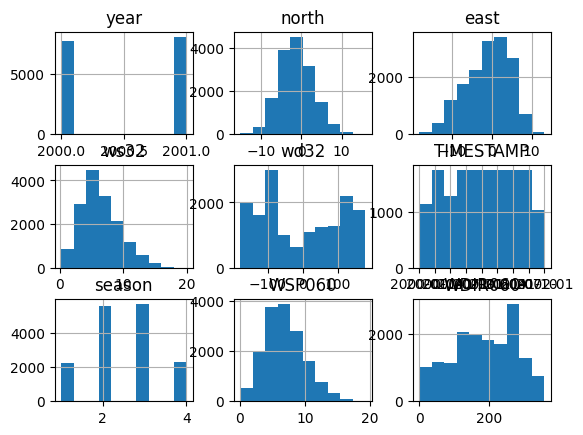

In [75]:
# cleaning the data, assuming that ws125=0.15 and wd125=0 is an error, remove all records with these value combinations
resultv1 = (df_result_cleaned.loc[(df_result_cleaned['ws32'] != 0.15) | (df_result_cleaned['wd32'] != 0)])

resultv1.hist()
print('')

In [76]:
# as a result of plotting the data, certain outliers will be removed

data_without_outliers = resultv1.copy()

data_without_outliers = data_without_outliers.loc[(data_without_outliers['ws32'] > 0.2)]
data_without_outliers

,year,north,east,ws32,wd32,TIMESTAMP,season,WSP060,WDIR060
15569,2000,-7.711142,-0.337232,7.718513,-177.495873,2000-01-01 07:00:00,1,9.12,193.41
15570,2000,-7.957040,0.114860,7.957869,179.172990,2000-01-01 08:00:00,1,9.10,191.73
15571,2000,-8.141119,0.163778,8.142766,178.847518,2000-01-01 09:00:00,1,9.13,206.20
15572,2000,-8.072268,-1.100040,8.146877,-172.239881,2000-01-01 10:00:00,1,8.24,228.57
15573,2000,-5.566095,-2.847045,6.251966,-152.910356,2000-01-01 11:00:00,1,9.78,290.79
...,...,...,...,...,...,...,...,...,...
31305,2001,2.610936,-1.946982,3.256950,-36.711996,2001-12-31 19:00:00,4,5.83,347.81
31306,2001,1.988047,-0.541898,2.060578,-15.247166,2001-12-31 20:00:00,4,4.83,72.59
31307,2001,2.098691,1.483328,2.569974,35.252186,2001-12-31 21:00:00,4,3.88,96.69
31308,2001,-0.266234,1.478775,1.502550,100.206002,2001-12-31 22:00:00,4,3.33,135.23


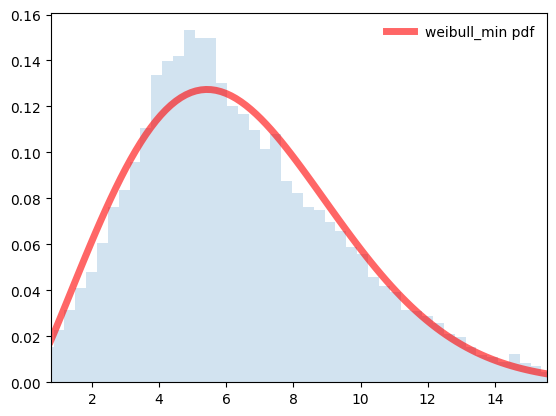

In [77]:
# check if ws follows weibull for mast windspeed

c, loc, scale = weibull_min.fit(data_without_outliers['ws32'].values)

fig, ax = plt.subplots(1, 1)
x = np.linspace(weibull_min.ppf(0.005, c,loc= loc, scale = scale),
                weibull_min.ppf(0.995, c, loc= loc, scale = scale), 100)
ax.plot(x, weibull_min.pdf(x, c, loc= loc, scale = scale),
       'r-', lw=5, alpha=0.6, label='weibull_min pdf')

ax.hist(data_without_outliers['ws32'].values, density=True, bins='auto', histtype='stepfilled', alpha=0.2)

ax.set_xlim([x[0], x[-1]])

ax.legend(loc='best', frameon=False)

plt.show()

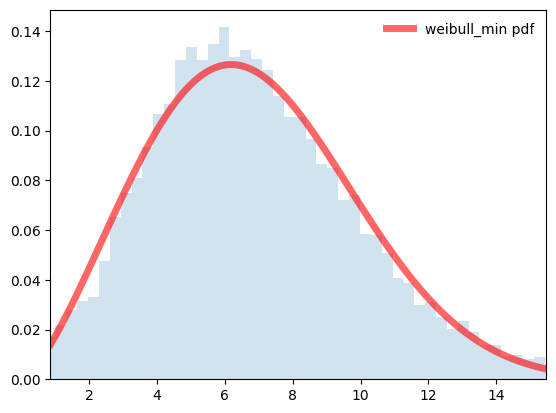

In [78]:
# check if ws follows weibull for meso windspeed

c, loc, scale = weibull_min.fit(data_without_outliers['WSP060'].values)
fig, ax = plt.subplots(1, 1)
x = np.linspace(weibull_min.ppf(0.005, c, loc= loc, scale = scale),
                weibull_min.ppf(0.995, c, loc=loc, scale = scale), 100)
ax.plot(x, weibull_min.pdf(x, c, loc= loc, scale = scale),
       'r-', lw=5, alpha=0.6, label='weibull_min pdf')

ax.hist(data_without_outliers['WSP060'].values, density=True, bins='auto', histtype='stepfilled', alpha=0.2)

ax.set_xlim([x[0], x[-1]])

ax.legend(loc='best', frameon=False)

plt.show()

In [79]:
#drop the timestamp and checking the correlation of the data
data_without_outliers.corr()

data_without_outliersv2 = data_without_outliers.drop(['TIMESTAMP'], axis = 1)

my_corr = data_without_outliersv2.corr()
display(my_corr[(my_corr > 0.75) | (my_corr < -0.75)].dropna(thresh=2).dropna(thresh=2, axis=1))
display(my_corr)

data_without_outliersv2.corr()

,ws32,WSP060
ws32,1.000000,0.855486
WSP060,0.855486,1.000000


,year,north,east,ws32,wd32,season,WSP060,WDIR060
year,1.000000,0.134739,0.016256,-0.080262,-0.042884,-0.139415,-0.104507,-0.042208
north,0.134739,1.000000,-0.046978,-0.124503,-0.004427,-0.075637,-0.146044,-0.104065
east,0.016256,-0.046978,1.000000,-0.354878,0.703465,0.150804,-0.206601,-0.680307
ws32,-0.080262,-0.124503,-0.354878,1.000000,-0.148342,-0.079243,0.855486,0.198452
wd32,-0.042884,-0.004427,0.703465,-0.148342,1.000000,0.147277,-0.056349,-0.505609
season,-0.139415,-0.075637,0.150804,-0.079243,0.147277,1.000000,-0.047312,-0.061711
WSP060,-0.104507,-0.146044,-0.206601,0.855486,-0.056349,-0.047312,1.000000,0.113394
WDIR060,-0.042208,-0.104065,-0.680307,0.198452,-0.505609,-0.061711,0.113394,1.000000


,year,north,east,ws32,wd32,season,WSP060,WDIR060
year,1.000000,0.134739,0.016256,-0.080262,-0.042884,-0.139415,-0.104507,-0.042208
north,0.134739,1.000000,-0.046978,-0.124503,-0.004427,-0.075637,-0.146044,-0.104065
east,0.016256,-0.046978,1.000000,-0.354878,0.703465,0.150804,-0.206601,-0.680307
ws32,-0.080262,-0.124503,-0.354878,1.000000,-0.148342,-0.079243,0.855486,0.198452
wd32,-0.042884,-0.004427,0.703465,-0.148342,1.000000,0.147277,-0.056349,-0.505609
season,-0.139415,-0.075637,0.150804,-0.079243,0.147277,1.000000,-0.047312,-0.061711
WSP060,-0.104507,-0.146044,-0.206601,0.855486,-0.056349,-0.047312,1.000000,0.113394
WDIR060,-0.042208,-0.104065,-0.680307,0.198452,-0.505609,-0.061711,0.113394,1.000000


## Model development